## Install Dependencies

In [1]:
# !pip install PyPDF2
# !pip install gensim
# !pip install nltk
# !pip install WordCloud
# !pip install pdfminer3
# !pip install mlflow
# !pip3 install spacy
# !pip3 install pyLDAvis==2.1.2

In [2]:
# !pip freeze

---
## Import Libraries

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import pandas as pd
import numpy as np

# pd.options.display.max_columns = 50
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 50)

plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

In [11]:
import sys  
sys.path.append('../src') 
from edge import *

In [12]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# PDF text extraction
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import PDFPageAggregator
from pdfminer3.converter import TextConverter

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Others
import requests
import io
import string
import re
from pprint import pprint
from tqdm.notebook import tqdm
import io

c:\Users\anany\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


Create Folders

In [13]:
DATA_FOLDER = '../data/'
PDF_FOLDER = '../pdf/'
createfolder(DATA_FOLDER)
createfolder(PDF_FOLDER)

### Loading Language Model

In [14]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anany\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anany\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\anany\anaconda3\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Preparing Stop Words

In [15]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

In [16]:
', '.join(stop_words)

"wasn't, nothing, put, hence, mustn, across, couldnt, describe, hasn't, is, these, weren, hasn, everyone, every, you'll, below, hadn, haven't, ltd, bottom, cannot, noone, yourselves, before, eight, having, shan, you're, wasn, won, sincere, side, least, off, six, may, was, though, which, now, nine, thru, less, bill, two, whom, isn, co, meanwhile, rather, becoming, everywhere, only, both, cant, whoever, empty, us, once, more, that, becomes, mine, will, no, you'd, doesn, don, latterly, until, together, on, something, by, yours, amongst, still, amount, thus, y, after, serious, my, please, theirs, you've, enough, needn, upon, third, seems, haven, fifty, mostly, between, for, through, hereupon, hereby, other, forty, whenever, namely, shan't, beyond, during, among, nobody, afterwards, also, inc, just, while, anywhere, aren, sometime, her, out, me, further, ten, then, our, keep, seem, isn't, up, always, couldn't, never, m, former, themselves, ie, its, nowhere, at, into, you, whether, from, or,

## Report Details

Enter required information about the report.  Report must be in PDF format and downloadable from a URL.

1. Company Name
2. Company Ticker Symbol
3. Year of the Report
4. URL of the Report

In [17]:
#report_company = 'citibank'
#report_ticker = 'C'
#report_year = '2019'
#report_url = 'https://www.citigroup.com/citi/about/esg/download/2019/Global-ESG-Report-2019.pdf?ieNocache=979'

In [ ]:
report_company = 'DFG'
report_ticker = 'C'
report_year = '2020'
report_url = 'http://127.0.0.1:8000/reportpdf/4/2020'

Additional information - ESG Score from Yahoo Finance

In [18]:
import yfinance as yf

ticker_info = yf.Ticker(report_ticker)
esg_data = pd.DataFrame(ticker_info.sustainability)
esg_data.columns = [str(ticker_info.ticker)]

esg_data.loc[['totalEsg','socialScore','governanceScore','environmentScore',
              'esgPerformance','percentile','peerGroup','highestControversy'],:]

,C
2022-8,
totalEsg,26.68
socialScore,13.11
governanceScore,11.82
environmentScore,1.75
esgPerformance,AVG_PERF
percentile,50.69
peerGroup,Banks
highestControversy,4


## Text Extraction
Extract information from the PDF report.  This process may take some time.  Do be patient.

*You may skip to the last step of this section if you have previously extracted the contents and stored in a json file.*

In [19]:
def extract_pdf(file, verbose=False):
    
    if verbose:
        print('Processing {}'.format(file))

    try:
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        codec = 'utf-8'
        laparams = LAParams()

        converter = TextConverter(resource_manager, fake_file_handle, codec=codec, laparams=laparams)
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
        
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()

        content = []

        for page in PDFPage.get_pages(file,
                                      pagenos, 
                                      maxpages=maxpages,
                                      password=password,
                                      caching=True,
                                      check_extractable=False):

            page_interpreter.process_page(page)

            content.append(fake_file_handle.getvalue())

            fake_file_handle.truncate(0)
            fake_file_handle.seek(0)        

        text = '##PAGE_BREAK##'.join(content)

        # close open handles
        converter.close()
        fake_file_handle.close()
        
        return text

    except Exception as e:
        print(e)

        # close open handles
        converter.close()
        fake_file_handle.close()

        return ""

In [20]:
def extract_content(url):
    """
    A simple user define function that, given a url, download PDF text content
    Parse PDF and return plain text version
    """
    headers={"User-Agent":"Mozilla/5.0"}

    try:
        # retrieve PDF binary stream
        r = requests.get(url, allow_redirects=True, headers=headers)
        
        # access pdf content
        text = extract_pdf(io.BytesIO(r.content))

        # return concatenated content
        return text

    except:
        return ""

In [21]:
report_content = extract_content(report_url)

Storing all information in a json file

In [22]:
import json

In [23]:
report = {'company':report_company, 'year':report_year, 'ticker':report_ticker, 
          'url':report_url, 'content':report_content}

with open(DATA_FOLDER + report_company+report_year+'.json', "w") as outfile:  
    json.dump(report, outfile)

Reloading the json file when required

In [24]:
with open(DATA_FOLDER + 'citibank2019.json') as inputfile:
     report = json.load(inputfile)

---

## Natural Language Processing

### Extracting content by pages and sentences

1. Only properly structured sentences are extracted.  Sentences that start with a Capital Letter and ends with a period.  Sentences that are less than 10 words or more than 50 words are ignored.  
2. Pages with less than 500 words are excluded from extraction.  Would like to focus on pages with mostly text content.  This should exclude pages like cover and last page.  It should also exclude pages that are more graphical with short notes and comments.

In [25]:
def remove_non_ascii(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
    # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
    return not line.isupper()

def extract_sentences(nlp, text):
    """
    Extracting ESG statements from raw text by removing junk, URLs, etc.
    We group consecutive lines into paragraphs and use spacy to parse sentences.
    """
    MIN_WORDS_PER_PAGE = 500
    
    pages = text.split('##PAGE_BREAK##')
#     print('Number of Pages: {}'.format(len(pages)))

    lines = []
    for page in pages:
        
        # remove non ASCII characters
        text = remove_non_ascii(page)
        
        if len(text.split(' ')) < MIN_WORDS_PER_PAGE:
#             print('Skipped Page: {}'.format(len(text.split(' '))))
            continue
        
        prev = ""
        for line in text.split('\n\n'):
            # aggregate consecutive lines where text may be broken down
            # only if next line starts with a space or previous does not end with dot.
            if(line.startswith(' ') or not prev.endswith('.')):
                prev = prev + ' ' + line
            else:
                # new paragraph
                lines.append(prev)
                prev = line

        # don't forget left-over paragraph
        lines.append(prev)
        lines.append('##SAME_PAGE##')
        
    lines = '  '.join(lines).split('##SAME_PAGE##')
    
    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    
    sentences = []
    pages_content = []

    for line in lines[:-1]:
        # removing header number
        line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
        # removing trailing spaces
        line = line.strip()
        # words may be split between lines, ensure we link them back together
        line = re.sub(r'\s?-\s?', '-', line)
        # remove space prior to punctuation
        line = re.sub(r'\s?([,:;\.])', r'\1', line)
        # ESG contains a lot of figures that are not relevant to grammatical structure
        line = re.sub(r'\d{5,}', r' ', line)
        # remove emails
        line = re.sub(r'\S*@\S*\s?', '', line)
        # remove mentions of URLs
        line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
        # remove multiple spaces
        line = re.sub(r'\s+', ' ', line)
        # join next line with space
        line = re.sub(r' \n', ' ', line)
        line = re.sub(r'.\n', '. ', line)
        line = re.sub(r'\x0c', ' ', line)
        
        pages_content.append(str(line).strip())

        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

#           sentences += nltk.sent_tokenize(line)
            
    # Only interested in full sentences and sentences with 10 to 100 words.
    sentences = [s for s in sentences if re.match('^[A-Z][^?!.]*[?.!]$', s) is not None]
    sentences = [s.replace('\n', ' ') for s in sentences]
    sentences = [s for s in sentences if (len(s.split(' ')) > 10) & (len(s.split(' ')) < 100)]

    return pages_content, sentences

In [26]:
report_pages, report_sentences = extract_sentences(nlp, report['content'])

On best effort basis, excluding header and footer contents that are not relevant.

In [27]:
headers = ['Contents Our Approach to ESG Solutions for Impact How We Do Business Appendices', 'Citi 2019 ESG Report']

for header in headers:
    report_pages = [p.replace(header, "").strip() for p in report_pages]
    report_sentences = [p.replace(header, "").strip() for p in report_sentences]    

### Tokenization, Bigrams and Lemmatization

In [28]:
def run_NLP(content):

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    data_words = list(sent_to_words(content))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return data_lemmatized

Using full text content in a page rather than full text content in a sentence here.  A page defined as a document as per TFIDF calculation.  

In [29]:
data_lemmatized = run_NLP(report_pages)

In [30]:
report_sentences_lemma = [' '.join(w) for w in data_lemmatized]

In [31]:
import random
report_sentences_lemma[random.randint(0, len(report_sentences_lemma))]

'assurance report citigroup environmental governance report section project cover equator_principle nature scope assurance verification sgs commission citigroup conduct independent assurance environmental governance report section project cover equator_principle scope assurance base sustainability report assurance methodology include datum accompany table contain report information citis environmental governance report citigroup presentation responsibility director management citigroup sgs involve preparation material include environmental governance report responsibility express opinion text datum graphs statement scope verification intention inform citigroup stakeholder sgs protocol base internationally recognize assurance standard isae standard follow differ option assurance depend context capability report organization report assure limited level scrutiny use protocol evaluation content veracity alignment equator_principle internal policy procedure citigroup assurance comprise comb

Relevant sentences are now well defined for ESG corpus.

### Word Cloud - Corpus Wide Term Frequencies

In [32]:
# context specific keywords not to include in topic modelling
fsi_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'report',
  'annualreport', 'long', 'make'
]

fsi_stop_words.append(report_company)
fsi_stop_words.append('citi')

# our list contains all english stop words + companies names + specific keywords
stop_words = stop_words.union(fsi_stop_words)

c:\Users\anany\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\anany\anaconda3\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\anany\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\anany\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

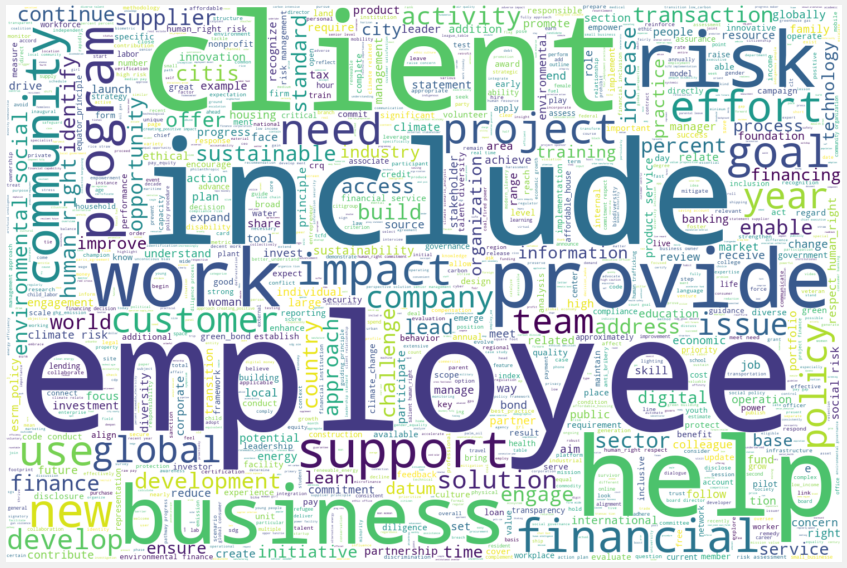

In [33]:
from wordcloud import WordCloud

# aggregate all 7200 records into one large string to run wordcloud on term frequency
large_string = ' '.join(report_sentences_lemma)

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=1500, 
    height=1000, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(16,16))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### TFIDF - Unigram and Bigram Analysis

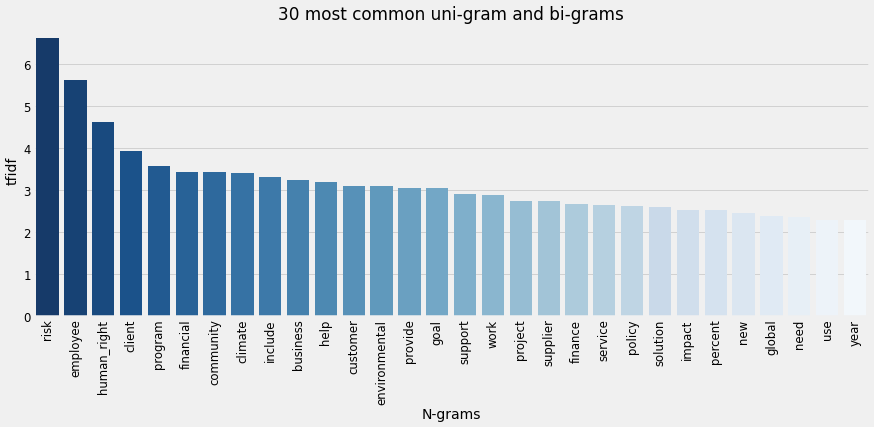

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(report_sentences_lemma)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top 10 ngrams
plt.figure(figsize=(16, 6))
plt.subplot(title='30 most common uni-gram and bi-grams')
sns.barplot(x=x_pos, y=counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('N-grams')
plt.ylabel('tfidf')
plt.show()

---


## Topic Modeling and Latent Dirichlet Allocation (LDA)

Evaluaton Metrics
1. **Perplexity**: Captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.  Lower the better.
2. **Coherence Score**: Measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.  Higher the better.

In the analysis, the model with the highest coherence score is selected as the optimal model.

In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [36]:
results = []
optimal_score = 0
optimal_model = None

for num_of_topics in tqdm(range(2,15,1)):
    
    result = {}
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_of_topics, 
                                                random_state=42,
                                                update_every=1,
                                                chunksize=5,
                                                passes=20,
                                                alpha='auto',
                                                per_word_topics=True) 

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    if optimal_score < coherence_model_lda.get_coherence():
        optimal_score = coherence_model_lda.get_coherence()
        optimal_model = lda_model

    result['num_of_topics'] = num_of_topics
    result['perplexity'] = lda_model.log_perplexity(corpus)
    result['coherence_score'] = coherence_model_lda.get_coherence()
    
    results.append(result)
    
results = pd.DataFrame(results)  
results.set_index('num_of_topics', inplace=True) 

  0%|          | 0/13 [00:00<?, ?it/s]

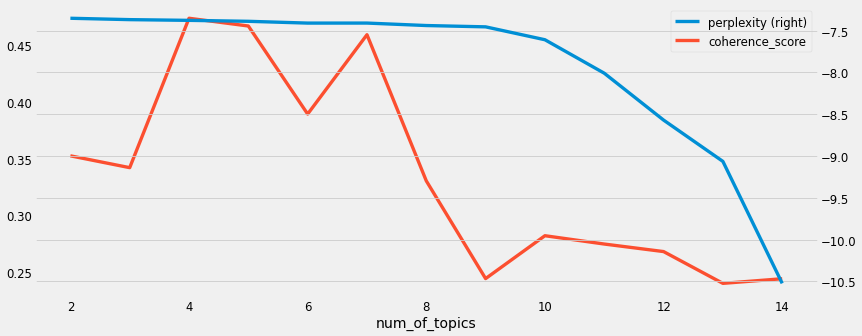

In [37]:
results.plot(secondary_y='perplexity')
plt.show()

In [38]:
results

,perplexity,coherence_score
num_of_topics,,
2,-7.351527,0.352403
3,-7.367937,0.341964
4,-7.376584,0.473685
5,-7.387935,0.466859
6,-7.409291,0.389236
7,-7.409042,0.459190
8,-7.438477,0.330313
9,-7.454193,0.244155
10,-7.608441,0.281955


In [39]:
# Compute Perplexity
print('\nPerplexity of the Optimal Model: ', optimal_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of the Optimal Model: ', coherence_lda)


Perplexity of the Optimal Model:  -7.376584294047984

Coherence Score of the Optimal Model:  0.473685014156804


---

## Visualize the topics

In [40]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.184746  0.090019       1        1  53.390272
0     -0.017837 -0.220160       2        1  34.266349
3     -0.033035  0.066852       3        1   9.242065
1      0.235618  0.063290       4        1   3.101314, topic_info=                Term        Freq       Total Category  logprob  loglift
355           report   94.000000   94.000000  Default  30.0000  30.0000
75     environmental   60.000000   60.000000  Default  29.0000  29.0000
659      human_right  140.000000  140.000000  Default  28.0000  28.0000
361             risk  137.000000  137.000000  Default  27.0000  27.0000
2167       assurance   27.000000   27.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
174          project    5.981978   49.197083   Topic4  -4.5809   1.3663
359   responsibility    3.644610   15.223668   Topic4  -5.0764   2.0437
128             lead    4.534253   38.221939   Topic4  -4.8580   1.3416
331     organization    4.264365   37.049349   Topic4  -4.9194   1.3114
108          include    4.605055  130.419977   Topic4  -4.8425   0.1297

[237 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1         1  0.989001     access
3048      4  0.662336  accompany
395       2  0.798885     action
395       3  0.208405     action
2         1  0.249061   activity
...     ...       ...        ...
1171      1  0.992550      woman
230       1  0.686054       work
230       2  0.305831       work
233       1  0.971948       year
233       2  0.015934       year

[290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

In [41]:
# Print the Keyword in the 10 topics
pprint(optimal_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"human_right" + 0.021*"risk" + 0.013*"policy" + 0.012*"employee" + '
  '0.011*"citi" + 0.010*"include" + 0.010*"report" + 0.010*"standard" + '
  '0.010*"management" + 0.010*"client"'),
 (1,
  '0.047*"report" + 0.046*"assurance" + 0.027*"citigroup" + '
  '0.026*"environmental" + 0.022*"equator_principle" + 0.020*"verification" + '
  '0.017*"governance" + 0.016*"sgs" + 0.015*"base" + 0.014*"scope"'),
 (2,
  '0.021*"citi" + 0.017*"employee" + 0.012*"program" + 0.010*"help" + '
  '0.009*"customer" + 0.008*"provide" + 0.008*"support" + 0.008*"work" + '
  '0.008*"business" + 0.008*"new"'),
 (3,
  '0.016*"tax" + 0.014*"product" + 0.013*"goal" + 0.012*"climate" + '
  '0.011*"energy" + 0.010*"finance" + 0.009*"power" + 0.008*"banking" + '
  '0.006*"client" + 0.006*"green_bond"')]


---

## Distinguishing the different ESG topics

In [42]:
topic_names = {0: 'support community', 1: 'value employees' , 2:'strong governance', 3:'ethical investments', 4:'focus customer', 5:'green energy', 6:'code of conduct', 7:'sustainable finance', 8:'company transformation' }

#     'value employees',
#     'ethical investments',
#     'strong governance',
#     'focus customer',    
#     'green energy',
#     'support community',
#     'code of conduct',
#     'sustainable finance',
#     'company transformation',


c:\Users\anany\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\anany\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\anany\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\anany\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

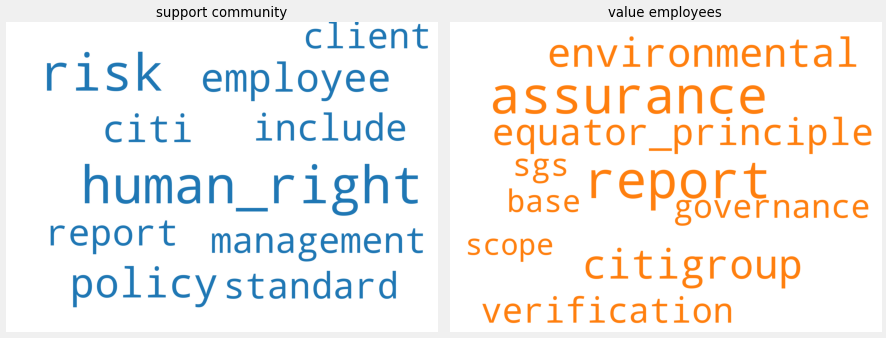

In [43]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()